# 人工知能とソフトコンピューティング 第7回 RNN 演習

## 分析対象となるデータの準備

ここでは名古屋市の日最高気温（1995/1/1～2022/12/31：28年間）のデータから，ある日の最高気温を予測するタスクを想定

In [100]:
# ベースパスの設定
base_path = '.'

### ステップ1
必要となるライブラリをインポート（tensorflowの使える環境を選択する必要あり）

In [101]:
from pathlib import Path # ファイルパスの取り扱い
import matplotlib.pyplot as plt # グラフ描画
import pandas as pd # データの取り扱い
from pandas import Series, DataFrame
from sklearn.preprocessing import StandardScaler # データの正規化（平均・標準偏差）
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import datetime # 時間関係（日付）の計算
import numpy as np # 数値取扱い
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as L
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics import Accuracy

### ステップ2
CSVファイルからデータを読み込み，その内容を確認する

,day,temp
0,1995/1/1,8.8
1,1995/1/2,9.7
2,1995/1/3,6.3
3,1995/1/4,9.2
4,1995/1/5,9.7


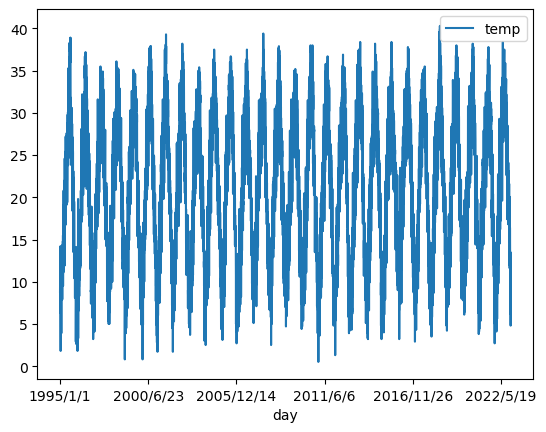

In [102]:
dataframe = pd.read_csv(Path(base_path, "07_data", "data.csv")) # data.csv というファイルからの読み込み
dataframe.plot(kind = "line", x = "day", y = "temp") # グラフ描画する
dataframe.head() # 先頭部分のデータを表示

### ステップ3
* 読み込んだ温度データの個数，最小値，最大値を確認
* 読み込んだデータを正規化するための層を設定（平均値を0，標準偏差を1に正規化）

In [103]:
# 読み込んだ温度データの値（データフレーム形式）を numpy形式の 2次元配列に変換
base_data = dataframe.temp.values.reshape(-1, 1)
# データ個数，最小温度，最大温度の表示
print("温度データ数 = {}".format(len(base_data)))
print("最小の温度 = {} ℃".format(np.min(base_data)))
print("最大の温度 = {} ℃".format(np.max(base_data)))

scaler = StandardScaler() # scikit-learn のスケーラ
scaler.fit(base_data) # 平均・標準偏差の計算
base_data = scaler.transform(base_data) # 標準化変換

温度データ数 = 10227
最小の温度 = 0.5 ℃
最大の温度 = 40.3 ℃


## 訓練用データとテスト用データの作成
一定の長さの日最高気温の系列を作成
* 直近 sequence_length 日をタイムステップとし，その期間の温度から翌日の温度を推定する
* sequence_length 日の気温の系列（入力データ）と sequence_length + 1 日目の気温（正解データ）を作成
* 訓練用データは1995年～2020年，テスト用データは 2021年から2022年とする

### ステップ4
系列長（sequence_length）を設定

* 系列長は RNN に入力する温度系列の長さ
* 系列長分の最高気温からその次の人温度を予測する問題

In [104]:
sequence_length = 60 # 遡って何日分の温度データから次の日の温度を予測するか（最大365日）
# sequence_length = 30\ # 遡って何日分の温度データから次の日の温度を予測するか（最大365日）
# sequence_length = 7 # 遡って何日分の温度データから次の日の温度を予測するか（最大365日）

### ステップ5
訓練用データとテスト用データを分割
* 訓練用データは 1995/1/1 ～ 2020/12/31 の26年間 9497件
* テスト用データは 2021/1/1 ～ 2022/12/31 の2年間 730件
* 過去26年分の温度データを用いて RNNを訓練して，2021, 22年の2年間の温度を予測
* 実際の予測では，sequence_length 日分のデータを入力して次の日の温度を予測

In [105]:
# 訓練用データ 1995/1/1 ～ 2016/12/31
training_data = base_data[: dataframe.index[dataframe["day"] == "2021/1/1"].tolist()[0]]
# 検証用データ 訓練用データからさらに 20% 分をランダムに抽出
# テスト用データ 2022/1/1 ～ 2022/12/31
test_data = base_data[dataframe.index[dataframe["day"] == "2021/1/1"].tolist()[0] :]

# 分割したデータの形式を確認
print(training_data.shape)
print(test_data.shape)

(9497, 1)
(730, 1)


### ステップ6
* 直近 sequence_length 日分の連続系列を作り出す関数（generate_dataset）を定義
* 例えば10日分であれば10日分の系列と，その次の日の温度（正解）を生成
  * (1/1, 2, 3, 4, 5, 6, 7, 8, 9, 10), (1/2, 3, ... , 11), (1/3, 4, ..., 12), ...
  * 1/11, 1/12, 1/13, ...
* 定義した関数を訓練用データ，テスト用データに適用

In [106]:
def generate_dataset(data, length): # length日分の連続系列を作り出す
    X = []
    y = []
    for i in range(len(data) - length):
        p = i + length
        X.append(data[i : p])
        y.append(data[p])
    return np.array(X), np.array(y)

# *_seqs は2次元配列：長さ sequence_length の温度値からなる系列が並んだもの
# *_targets は1次元配列：予測目標である温度値が並んだもの
training_seqs, training_targets = generate_dataset(training_data, sequence_length) # 訓練用の系列と正解値
test_seqs, test_targets = generate_dataset(test_data, sequence_length) # テスト用の系列と正解値
# RNNへの入力用に3階のテンソルの変換（データ個数，シーケンス長，データ次元数）
training_seqs = np.reshape(training_seqs, (-1, sequence_length, 1))
test_seqs = np.reshape(test_seqs, (-1, sequence_length, 1))
# 具体的なデータやその形式を確認したい場合は次の4行のコメントを外す
# print(training_seqs)
# print(training_seqs.shape)
# print(training_targets)
# print(training_targets.shape)

# NumPy配列をPyTorchのテンソルに変換
training_seqs = torch.Tensor(training_seqs)
training_targets = torch.Tensor(training_targets)
test_seqs = torch.Tensor(test_seqs)
test_targets = torch.Tensor(test_targets)

# TensorDataset に変換
# 検証用データを訓練用データの末尾から20%分抽出
val_size = int(len(training_seqs) * 0.2)
train_size = len(training_seqs) - val_size
train_dataset = TensorDataset(training_seqs[:train_size], training_targets[:train_size])
val_dataset = TensorDataset(training_seqs[train_size:], training_targets[train_size:])

## RNNの構造定義と訓練

### ステップ7
RNNの構造定義
* 基本的なRNNを適用
* RNN を LSTM や GRU に変更可能
* num_lahyers オプションで RNNを複数層重ねることもできる
* bidirectional オプションを用いることで双方向へのデータの伝播も可能（隠れ層のサイズの調整は必要）

In [107]:
class RNN(L.LightningModule):
    def __init__(self, input_size, rnn_hidden_size):
        super().__init__()
        self.save_hyperparameters() # ハイパーパラメータを保存
        self.example_input_array = torch.zeros((1, sequence_length, 1)) # データ数1，シーケンス長 sequence_length，データ次元数 1

        # RNN: 最も単純なRNN層を定義．系列データをずらしながら入力
        #            ユニット数（層の出力の次元数）64 (変更可）のデータを次の層へ出力
        #            活性化関数は tanh（ハイパボリックタンジェント：変更可）
        # self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size, nonlinearity='tanh',
        #                  num_layers=1, bidirectional=False,
        #                  batch_first=True)

        # # RNN層をLSTMにする場合
        # self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
        #                     batch_first=True)
        # RNN層をGRUにする場合
        self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
                           batch_first=True)
        #
        # RNN層を複数にする場合は num_layers を増やす
        # self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size, nonlinearity='tanh',
        #                    num_layers=2,
        #                    batch_first=True)
        # RNN層を双方向（前の時刻，後の時刻への伝播を両方含む）ものにする場合，bidirectional=Trueにする
        # 両方向の hidden_size を足し合わせたものが 次のLayerに入力されるので、rnn_hidden_sizeを2で割っている
        # self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size // 2, nonlinearity='tanh',
        #                    bidirectional=True,
        #                    batch_first=True)
        #        
        # Layer: 全結合のニューロン層 ユニット数 1，活性化関数（出力関数） linear（変換なしでそのまま出力）
        self.dense = nn.Linear(in_features=rnn_hidden_size, out_features=1)
        # 双方向RNNの場合は in_features=rnn_hidden_size * 2 にする
        # self.dense = nn.Linear(in_features=rnn_hidden_size * 2, out_features=1)

        # 損失関数: 回帰問題なので平均二乗誤差（MSE）
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        # RNN層への入力と実行
        # rnn_out: 全タイムステップの出力 (batch_size, sequence_length, rnn_units)
        # h_n: 最終層の最後の隠れ状態 (num_layers * num_directions, batch_size, rnn_units)
        rnn_out, h_n = self.rnn(x)
        # 最終時刻の出力を取り出す
        out = rnn_out[:, -1, :]
        # 最終時刻の出力を全結合層へ入力
        out = self.dense(out) # 全結合層への入力
        return out
    
    def configure_optimizers(self):
        # オプティマイザ:
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01) # デフォルトの学習率を設定
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # on_epoch=True でエポック終了時に平均値を記録
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # on_epoch=True でエポック終了時に平均値を記録
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # on_epoch=True でエポック終了時に平均値を記録
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)



(RNN(input_size=1, rnn_hidden_size=64))
# (RNN(input_size=1, rnn_hidden_size=128))
# (RNN(input_size=1, rnn_hidden_size=32))

RNN(
  (rnn): GRU(1, 64, batch_first=True)
  (dense): Linear(in_features=64, out_features=1, bias=True)
  (criterion): MSELoss()
)

### ステップ8
作成したモデルの訓練
* 損失関数は平均二乗誤差（mean_squared_error）
* 最適化アルゴリズムは Adam
* エポック数 100（ただし損失の値に変化がなくなったら訓練を打ち切る EarlyStopping コールバックを利用）
* バッチサイズ 32

In [108]:
epochs = 100 # 最大エポック数
batch_size = 32 # バッチサイズ
patience = 20 # 訓練を打ち切る場合でも最低20エポックまでは訓練する

# 1. データローダーとモデルのインスタンス化

# 入力データ：training_seqs 気温の系列データ
# 正解データ：training_targets 各系列に対する翌日の気温
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# バッチサイズ：32（このセルの先頭部分の batch_size）
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

model_rnn = RNN(input_size=1, rnn_hidden_size=64)
# model_rnn = RNN(input_size=1, rnn_hidden_size=32)

checkpoint_callback = L.callbacks.ModelCheckpoint(
    save_last=True,
)
# erly stopping コールバックの設定（検証データの損失が改善しなくなったら学習を終了する）
early_stopping_callback = L.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min'
)

log_folder = Path(base_path, "logs")
rnn_logger = L.loggers.CSVLogger(log_folder, name='rnn')
rnn_trainer = L.Trainer(
    max_epochs=epochs, # エポック数：100（このセルの先頭部分の epochs）
    logger=rnn_logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    deterministic=True,
    enable_progress_bar=True
)

# モデルの訓練
rnn_trainer.fit(model_rnn, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
checkpoint_path = checkpoint_callback.last_model_path
stopped_epoch = rnn_trainer.early_stopping_callback.stopped_epoch

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode  | In sizes   | Out sizes                
---------------------------------------------------------------------------------------
0 | rnn       | GRU     | 12.9 K | train | [1, 60, 1] | [[1, 60, 64], [1, 1, 64]]
1 | dense     | Linear  | 65     | train | [1, 64]    | [1, 1]                   
2 | criterion | MSELoss | 0      | train | ?          | ?                        
---------------------------------------------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 42: 100%|██████████| 236/236 [00:10<00:00, 21.84it/s, v_num=19, val_loss=0.101, train_loss=0.0968] 


### ステップ9
訓練履歴の確認
* 訓練中のエポック毎の損失値（平均二乗誤差）の推移を描画
* ここでの損失は平均と標準偏差によってデータを標準化したものに対する値であることに注意
* グラフ描画の関数を定義して適用

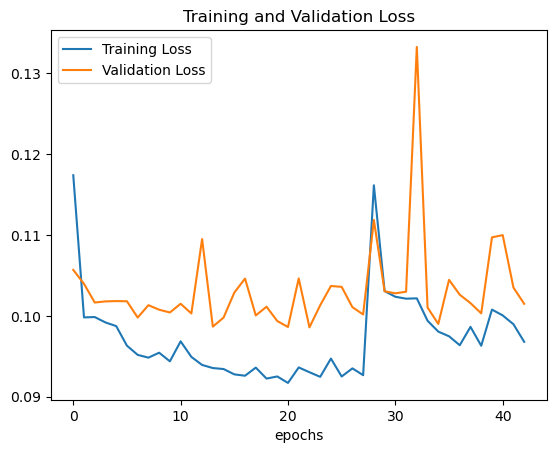

In [109]:
def load_history(log_path):
    log_file = Path(log_path, "metrics.csv")
    history = pd.read_csv(log_file)
    # 記録のタイミングにより欠損値があるため，欠損値のある行を削除
    train_history = history.dropna(subset=['train_loss']).reset_index(drop=True) 
    val_history = history.dropna(subset=['val_loss']).reset_index(drop=True)
    return train_history, val_history

def show_loss_graphs(train_history, val_history, epochs, epoch_from = 0): # 訓練履歴（精度・損失）を描画する関数
    training_losses = train_history["train_loss"] # 訓練用データに対する損失
    validation_losses = val_history["val_loss"] # 評価用データに対する損失
    
    epochs_range = range(epoch_from, epochs + 1) # 1 から epochs までの描画範囲を指定
    figure = plt.figure()
    subplot = plt.subplot()
    subplot.plot(epochs_range, training_losses, label = "Training Loss") # 訓練用データに対する損失のグラフ描画
    subplot.plot(epochs_range, validation_losses, label = "Validation Loss") # 評価用データに対する損失のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    # plt.ylim(0, 0.2) # 複数のモデルに対して損失値のグラフを比べたい場合，この行のコメントを外し，固定の上限値，下限値を指定する
    plt.title("Training and Validation Loss")
    plt.show()

log_path = Path(log_folder, "rnn", f"version_{rnn_trainer.logger.version}")
rnn_train_history, rnn_val_history = load_history(log_path)
show_loss_graphs(rnn_train_history, rnn_val_history, stopped_epoch) # 損失値のグラフを描画

## 予測タスクの実行
テスト用データを与えて最高気温を予測する

## ステップ10
* 訓練したモデルに2021/1/1から2022/12/31までのデータを与えて予測
* 出力されるのは平均と標準偏差を用いて変換したものなので，逆変換

In [110]:
# 系列データを与えて予測
test_dataloader = DataLoader(
    test_seqs,
    batch_size=len(test_seqs),
    shuffle=False
)

predictions = rnn_trainer.predict(model_rnn, dataloaders=test_dataloader)
predictions = torch.cat(predictions, dim=0).numpy() # バッチごとの要素のリストを結合して1つのTensorにする

# 予測結果とテスト用の正解データを標準化逆変換
predictions_real = scaler.inverse_transform(predictions)
targets_real = scaler.inverse_transform(test_targets)

# 誤差に関する値を表示（平方根平均二乗誤差，平均絶対誤差，平均絶対パーセント誤差）
print("平方根平均二乗誤差（RMSE）= {} ℃".format(np.sqrt(mean_squared_error(targets_real, predictions_real))))
print("平均絶対誤差（MAE）= {} ℃".format(mean_absolute_error(targets_real, predictions_real)))
print("平均絶対パーセント誤差（MAPE）= {} %".format(mean_absolute_percentage_error(targets_real, predictions_real) * 100))

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]
平方根平均二乗誤差（RMSE）= 2.8121631751653453 ℃
平均絶対誤差（MAE）= 2.232759876159576 ℃
平均絶対パーセント誤差（MAPE）= 12.808144473395211 %


### ステップ11
予測結果のグラフ描画
* 2022/1/1から2022/12/31までの結果
* 2022/1から2022/12までの1ヶ月ずつの予測結果

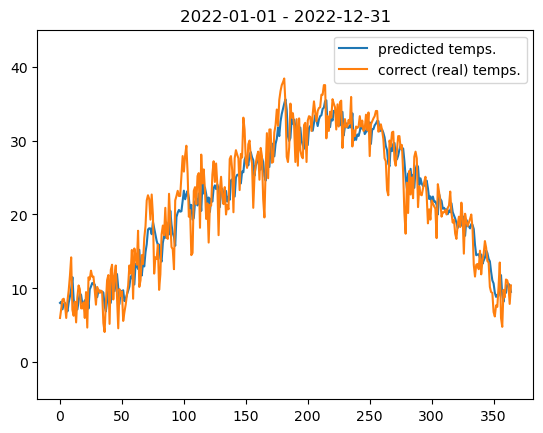

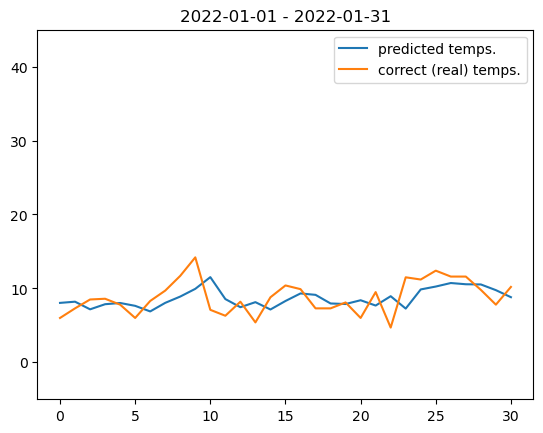

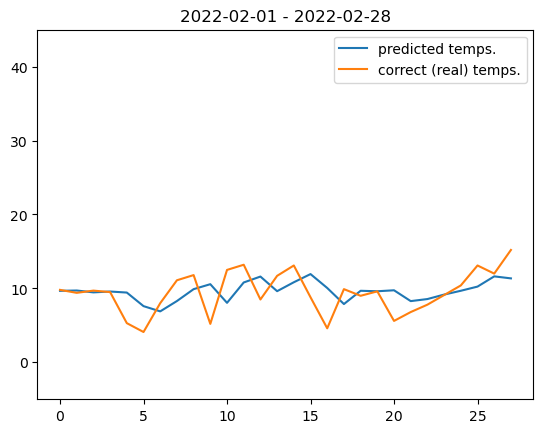

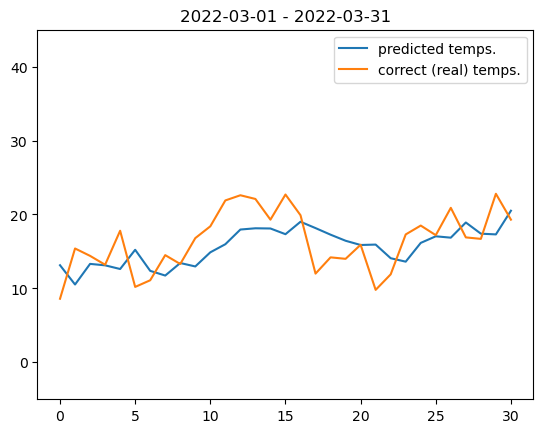

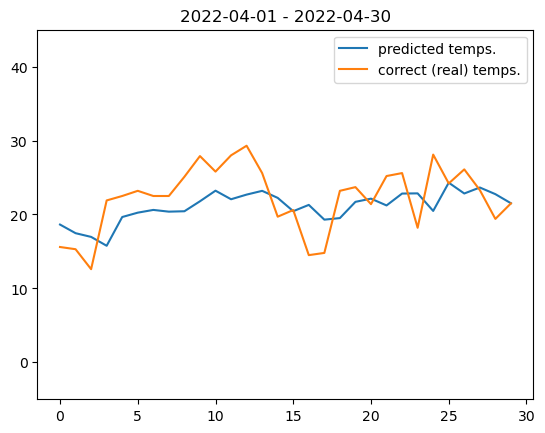

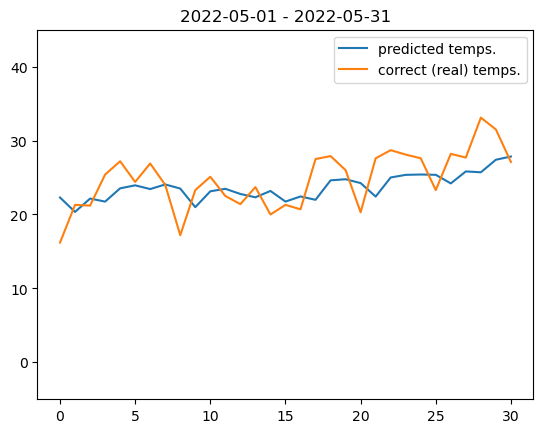

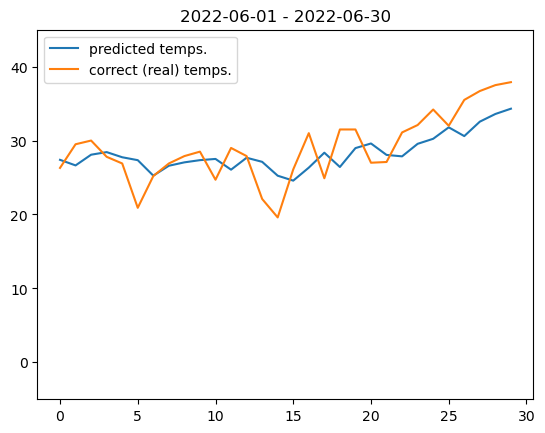

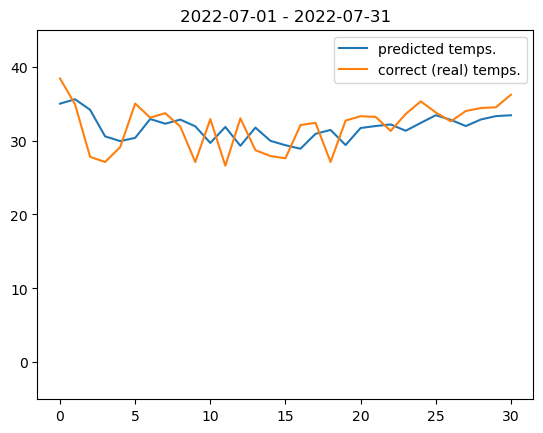

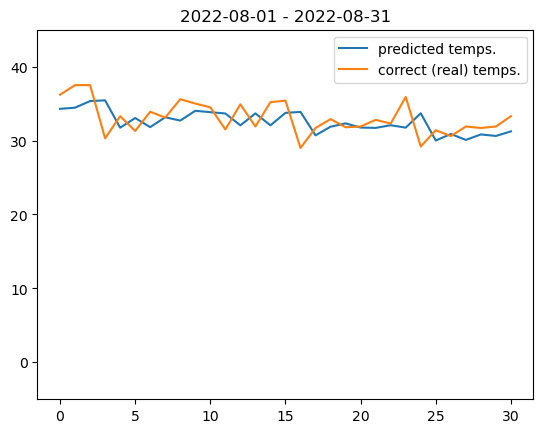

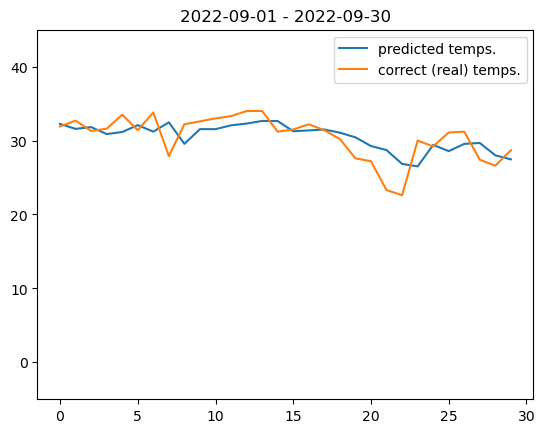

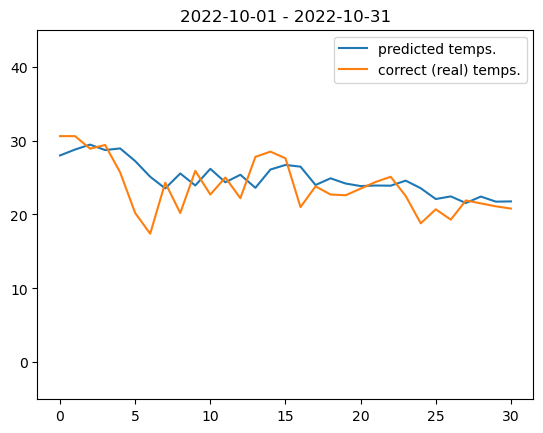

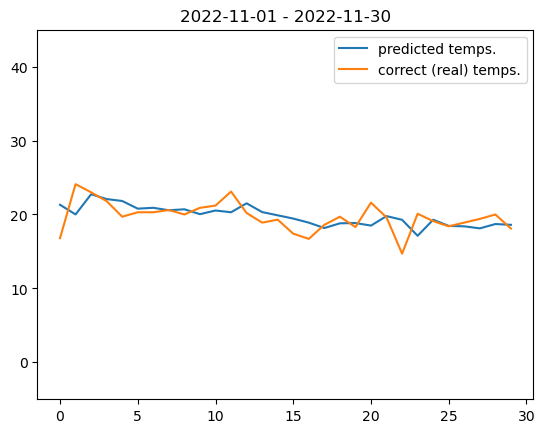

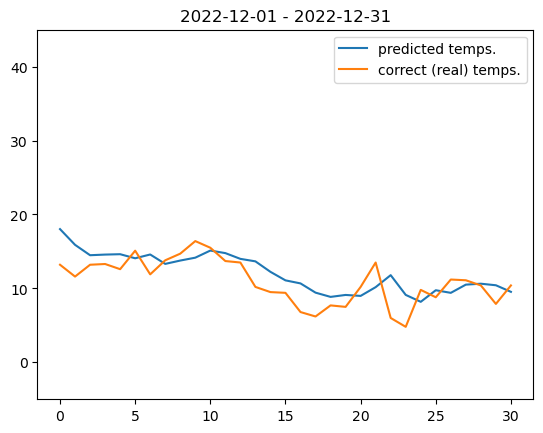

In [111]:
def show_result(predictions, targets, title = ""): # 予測結果と正解のグラフを表示する関数
    plt.plot(predictions, label = "predicted temps.")
    plt.plot(targets, label = "correct (real) temps.")
    plt.ylim(-5.0, 45.0) # グラフの比較ができるように温度の範囲を固定（-5℃～45℃）
    plt.title(title)
    plt.legend()
    plt.show()

# グラフ描画の開始日から終了日を指定して描画する関数を定義
# 開始日と終了日は 2022/1/1から2022/12/31までの間で指定（日付の間のエラーチェックなどはしていないので注意）
def show_result_with_start_and_end(start_date, end_date, offset, predictions, targets):
    # 予測結果・正解データの最初の日
    offset_date = datetime.date(year = 2021, month = 1, day = 1) + datetime.timedelta(days = offset)
    # 描画開始位置の計算
    diff_start = (start_date - offset_date).days 
    # 描画終了位置の計算
    diff_end = (end_date - offset_date).days + 1
    # 予測値と実際の値（正解）のグラフ描画
    show_result(predictions[diff_start : diff_end],
                targets[diff_start : diff_end],
                title = "{}".format(start_date) + " - {}".format(end_date))

# 2022/1/1 から 2022/12/31 までの予測結果と実際の値（正解）を描画
# 以下，テストデータは 2021/1/1から2022/12/31 までの範囲でしか与えられておらず，
# 予測結果や正解（実際の値）はその範囲に対するもののみであることに注意，
# 範囲外の日付（年・月・日）を指定するとうまく動かない
show_result_with_start_and_end(datetime.date(year = 2022, month = 1, day = 1), 
                               datetime.date(year = 2022, month = 12, day = 31), 
                               offset = sequence_length, predictions = predictions_real, targets = targets_real)

# 2022/1 から一か月ごとに予測結果と実際の値（正解）を描画
for i in range(1, 13):
    if i == 12: # 12月だけ特別扱い
        ey = 2023
        em = 1
    else:
        ey = 2022
        em = i + 1
    # 各月の1日から最終日までのグラフを描画
    show_result_with_start_and_end(datetime.date(year = 2022, month = i, day = 1),
                                   datetime.date(year = ey, month = em, day = 1) - datetime.timedelta(days = 1),
                                   offset = sequence_length, predictions = predictions_real, targets = targets_real)

# 課題：RNN設定変更による予測精度の調査

## 実験概要
名古屋の最高気温予測タスクについて、RNNの設定を変更し、予測の損失値や予測結果の変化を調査する。

---

## 実験結果

### 実験1：ベースライン（基本RNN）

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 35（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN) | 4,288 |
| dense (Linear) | 65 |
| 合計 | 4,353 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.123 |
| val_loss | 0.111 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 2.92 ℃ |
| MAE | 2.27 ℃ |
| MAPE | 13.62 % |

---

### 実験2：sequence_length = 7（1週間）

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 7 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 24（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN) | 4,288 |
| dense (Linear) | 65 |
| 合計 | 4,353 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.116 |
| val_loss | 0.183 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 3.78 ℃ |
| MAE | 3.16 ℃ |
| MAPE | 16.05 % |

**変更点と考察**：
- sequence_lengthを30から7に短縮（約1週間分のデータで予測）
- 精度が悪化：RMSE +0.86℃、MAE +0.89℃、MAPE +2.43%
- 過去1週間のデータだけでは、気温予測に必要な長期的なパターン（季節変動など）を捉えきれない可能性がある
- val_lossがtrain_lossより高く、汎化性能が低下している

---

### 実験3：隠れ層ユニット数 = 32

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 32 |
| バッチサイズ (batch_size) | 32 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 34（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN) | 1,120 |
| dense (Linear) | 33 |
| 合計 | 1,153 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.121 |
| val_loss | 0.138 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 3.21 ℃ |
| MAE | 2.52 ℃ |
| MAPE | 14.10 % |

**変更点と考察**：
- 隠れ層ユニット数を64から32に削減
- パラメータ数が約1/4に減少（4,353 → 1,153）
- 精度がやや悪化：RMSE +0.29℃、MAE +0.25℃、MAPE +0.48%
- ユニット数を減らすとモデルの表現力が低下し、予測精度が若干低下
- ただし、パラメータ削減の割には精度低下は小さく、効率的なモデルと言える

---

### 実験4：LSTM使用

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | LSTM (`nn.LSTM`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 49（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (LSTM) | 17,152 |
| dense (Linear) | 65 |
| 合計 | 17,217 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.090 |
| val_loss | 0.103 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 2.79 ℃ |
| MAE | 2.22 ℃ |
| MAPE | 13.33 % |

**変更点と考察**：
- RNNをLSTMに変更
- パラメータ数が約4倍に増加（4,353 → 17,217）
- **精度が向上**：RMSE -0.13℃、MAE -0.05℃、MAPE -0.29%
- LSTMはゲート機構により長期依存関係を学習しやすく、時系列予測に有効
- train_lossがval_lossより低く、適切に学習できている
- 学習エポック数も増加し、より深く学習できた

---

### 実験5：GRU使用

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | GRU (`nn.GRU`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 68（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (GRU) | 12,864 |
| dense (Linear) | 65 |
| 合計 | 12,929 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.098 |
| val_loss | 0.101 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 2.79 ℃ |
| MAE | 2.20 ℃ |
| MAPE | 13.01 % |

**変更点と考察**：
- RNNをGRUに変更
- パラメータ数はLSTMより少ない（12,929 vs 17,217）
- **最も良い精度を達成**：RMSE -0.13℃、MAE -0.07℃、MAPE -0.61%（ベースライン比）
- GRUはLSTMより構造がシンプルだが、同等以上の性能を発揮
- 学習エポック数が最も多く（68エポック）、より深く学習できた
- train_lossとval_lossの差が小さく、過学習していない

---

### 実験6：多層RNN（num_layers = 2）

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 2 |
| 双方向 (bidirectional) | False |
| 実際の学習エポック数 | 21（Early Stopping） |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN, 2層) | 12,608 |
| dense (Linear) | 65 |
| 合計 | 12,673 |

**損失値**
| 指標 | 値 |
|------|-----|
| train_loss | 0.507 |
| val_loss | 0.513 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 6.59 ℃ |
| MAE | 5.36 ℃ |
| MAPE | 29.15 % |

**変更点と考察**：
- RNN層を1層から2層に増加
- パラメータ数が約3倍に増加（4,353 → 12,673）
- **精度が大幅に悪化**：RMSE +3.67℃、MAE +3.09℃、MAPE +15.53%（ベースライン比）
- 損失値（train_loss, val_loss）も非常に高く、学習がうまく進んでいない
- 多層RNNは勾配消失問題が発生しやすく、基本RNNでは深い構造が学習困難
- 多層構造にする場合はLSTMやGRUを使用する方が適切

---

### 実験7：双方向RNN（Bidirectional RNN）

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 32 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | True |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN, bidirectional) | 8,576 |
| dense (Linear) | 129 |
| 合計 | 8,705 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 3.26 ℃ |
| MAE | 2.56 ℃ |
| MAPE | 15.45 % |

**変更点と考察**：
- 双方向RNNを使用（順方向と逆方向の両方から時系列を処理）
- パラメータ数が約2倍に増加（4,353 → 8,705）
- **精度が悪化**：RMSE +0.34℃、MAE +0.29℃、MAPE +1.83%（ベースライン比）
- 双方向RNNは「未来の情報」も使って特徴を抽出するが、気温予測タスクでは予測時点で未来のデータは利用不可
- 時系列予測（特にリアルタイム予測）には双方向RNNは不向き
- 双方向RNNは自然言語処理（文全体が既知の場合）などに適している

---

### 実験8：バッチサイズ = 64

| 設定項目 | 値 |
|---------|-----|
| sequence_length | 30 |
| RNNアーキテクチャ | 基本RNN (`nn.RNN`) |
| 隠れ層サイズ (rnn_hidden_size) | 64 |
| バッチサイズ (batch_size) | 64 |
| 活性化関数 | tanh |
| 層数 (num_layers) | 1 |
| 双方向 (bidirectional) | False |

**モデル構造**
| レイヤー | パラメータ数 |
|---------|------------|
| rnn (RNN) | 4,288 |
| dense (Linear) | 65 |
| 合計 | 4,353 |

**予測精度（テストデータ）**
| 指標 | 値 |
|------|-----|
| RMSE | 2.94 ℃ |
| MAE | 2.33 ℃ |
| MAPE | 14.02 % |

**変更点と考察**：
- バッチサイズを32から64に増加
- モデル構造（パラメータ数）は変わらない
- **精度がわずかに悪化**：RMSE +0.02℃、MAE +0.06℃、MAPE +0.40%（ベースライン比）
- バッチサイズ増加により、1エポックあたりの更新回数が減少
- 勾配の分散が小さくなり、より滑らかな学習となるが、局所最適解への収束が変わる可能性
- このタスクでは、バッチサイズ32の方がわずかに良い結果

---

## 結果のまとめ

| 実験 | 設定変更 | RMSE (℃) | MAE (℃) | MAPE (%) |
|------|---------|----------|---------|----------|
| 1 | ベースライン（seq=30, RNN, hidden=64, batch=32） | 2.92 | 2.27 | 13.62 |
| 2 | sequence_length = 7 | 3.78 | 3.16 | 16.05 |
| 3 | rnn_hidden_size = 32 | 3.21 | 2.52 | 14.10 |
| 4 | LSTM使用 | 2.79 | 2.22 | 13.33 |
| 5 | GRU使用 | **2.79** | **2.20** | **13.01** |
| 6 | 多層RNN（num_layers=2） | 6.59 | 5.36 | 29.15 |
| 7 | 双方向RNN（bidirectional） | 3.26 | 2.56 | 15.45 |
| 8 | batch_size = 64 | 2.94 | 2.33 | 14.02 |

## 考察

### 1. 最も良い結果
**GRU（実験5）** が最も良い予測精度を達成した（RMSE=2.79℃、MAPE=13.01%）。LSTMと同等のRMSEながら、パラメータ数が少なく効率的である。

### 2. 設定変更の影響

**精度向上に寄与した設定：**
- **ゲート機構のあるアーキテクチャ（LSTM, GRU）**: 長期依存関係を効果的に学習でき、基本RNNより精度向上
- **適切なsequence_length（30日）**: 気温の季節パターンを捉えるのに十分な長さ

**精度悪化につながった設定：**
- **sequence_length短縮（7日）**: 長期パターンを捉えられず精度悪化
- **隠れ層サイズ削減（32）**: モデルの表現力低下で精度悪化（ただし軽微）
- **多層RNN（num_layers=2）**: 勾配消失問題により学習が困難で大幅悪化
- **双方向RNN**: 未来情報を使う構造だが、予測時には未来データが無いため不向き
- **バッチサイズ増加（64）**: わずかに精度悪化（更新回数減少による影響）

### 3. 気温予測タスクへの示唆
- 時系列予測には**GRU**が最もバランスが良い（精度・効率の両立）
- 過去30日程度のデータで十分な精度が得られる
- 多層構造や双方向構造は、このタスクには不向き
- バッチサイズは32程度が適切